In [113]:
from qdrant_client import QdrantClient, models

try:
    # Initialize the Qdrant client to connect to your local Qdrant server
    client = QdrantClient(host='192.168.4.43', port=6333, timeout=60)
    print("Connected to Qdrant successfully!")
except Exception as e:
    print(f"Failed to connect to Qdrant: {e}")


Connected to Qdrant successfully!


In [114]:
from qdrant_client import QdrantClient


client = QdrantClient(host='192.168.4.43', port=6333, timeout=30)

# Create a new collection in Qdrant with configurations for both dense and sparse vectors
client.create_collection(
    collection_name="products_collection_with_images",
    vectors_config={
        "text-dense": {
            "size": 512,  
            "distance": "Dot"  
        }
    },
    sparse_vectors_config={
        "text-sparse": {
            "index": {
                "on_disk": True,
                "full_scan_threshold": 5000
            }
        }
    }
)


True

In [2]:
import qdrant_client
from qdrant_client import QdrantClient
from qdrant_client.http import models
from sentence_transformers import SentenceTransformer

In [55]:
import pandas as pd
import os

metadata_path = 'clean_metadata.csv'
metadata = pd.read_csv(metadata_path)

image_root_path = './Images/'
metadata['image'] = metadata.apply(lambda row: os.path.join(image_root_path, f"{row['id']}.jpg"), axis=1)
metadata['image_exists'] = metadata['image'].apply(os.path.exists)
metadata['articleType'] = metadata['category_name']
metadata['productDisplayName'] = metadata['name']
metadata['simplifiedDisplayName'] = metadata['simplified_name']
metadata['articleType_label'] = pd.factorize(metadata['articleType'])[0]
dataset = metadata[['image', 'id', 'articleType', 'productDisplayName', 'articleType_label', 'simplifiedDisplayName']]
dataset.head()

,image,id,articleType,productDisplayName,articleType_label,simplifiedDisplayName
0,./Images/1.jpg,1,Tools and Hardware,DeWalt DCS331N 18V Li-Ion XR Cordless Jigsaw -...,0,DeWalt cordless jigsaw
1,./Images/2.jpg,2,Tools and Hardware,Evolution R210SMS 210mm Electric Single-Bevel ...,0,Evolution SMS electric SingleBevel Sliding Mul...
2,./Images/3.jpg,3,Tools and Hardware,Evolution R255SMS-DB 255mm Electric Double-Bev...,0,Evolution SMSDB electric DoubleBevel Sliding M...
3,./Images/4.jpg,4,Tools and Hardware,Milwaukee M18 BLCS66-401B 190mm 18V 1 x 4.0Ah ...,0,Milwaukee RedLithium Brushless cordless Circul...
4,./Images/5.jpg,5,Tools and Hardware,Bosch GST 18V-Li 18V Li-Ion Coolpack Cordless ...,0,Bosch GST Coolpack cordless jigsaw


In [56]:
images = dataset["image"]
images
dataset = dataset.drop(columns=['image'])
product_df = dataset
product_df = product_df.rename(columns={"id": "Pid"})
product_df

,Pid,articleType,productDisplayName,articleType_label,simplifiedDisplayName
0,1,Tools and Hardware,DeWalt DCS331N 18V Li-Ion XR Cordless Jigsaw -...,0,DeWalt cordless jigsaw
1,2,Tools and Hardware,Evolution R210SMS 210mm Electric Single-Bevel ...,0,Evolution SMS electric SingleBevel Sliding Mul...
2,3,Tools and Hardware,Evolution R255SMS-DB 255mm Electric Double-Bev...,0,Evolution SMSDB electric DoubleBevel Sliding M...
3,4,Tools and Hardware,Milwaukee M18 BLCS66-401B 190mm 18V 1 x 4.0Ah ...,0,Milwaukee RedLithium Brushless cordless Circul...
4,5,Tools and Hardware,Bosch GST 18V-Li 18V Li-Ion Coolpack Cordless ...,0,Bosch GST Coolpack cordless jigsaw
...,...,...,...,...,...
64390,64391,Paints and Coatings,Afonso Neutral white Integrated LED Batten 19W...,8,Afonso Neutral white Integrated LED Batten
64391,64392,Paints and Coatings,Luceco Cool white Integrated LED Batten 36W 36...,8,Luceco Cool white Integrated LED Batten
64392,64393,Paints and Coatings,GoodHome Gallius Neutral white Integrated LED ...,8,GoodHome Gallius Neutral white Integrated LED ...
64393,64394,Paints and Coatings,Luceco Cool white G13 LED Twin batten 36W 3000...,8,Luceco Cool white LED Twin batten


In [57]:
images

0            ./Images/1.jpg
1            ./Images/2.jpg
2            ./Images/3.jpg
3            ./Images/4.jpg
4            ./Images/5.jpg
                ...        
64390    ./Images/64391.jpg
64391    ./Images/64392.jpg
64392    ./Images/64393.jpg
64393    ./Images/64394.jpg
64394    ./Images/64395.jpg
Name: image, Length: 64395, dtype: object

In [82]:
from pinecone_text.sparse import BM25Encoder

bm25 = BM25Encoder()

In [84]:
bm25.fit(str(product_df['productDisplayName']))

  0%|          | 0/703 [00:00<?, ?it/s]

In [85]:
product_df['productDisplayName'][0]

'DeWalt DCS331N 18V Li-Ion XR Cordless Jigsaw - Bare'

In [86]:
bm25.encode_queries(product_df['productDisplayName'][0])

{'indices': [4215858208,
  3027477997,
  1233612093,
  4134280737,
  685068363,
  2487673192,
  542916100,
  1211141128],
 'values': [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125]}

In [87]:
bm25.encode_documents(product_df['productDisplayName'][0])

{'indices': [4215858208,
  3027477997,
  1233612093,
  4134280737,
  685068363,
  2487673192,
  542916100,
  1211141128],
 'values': [0.11764705882352941,
  0.11764705882352941,
  0.11764705882352941,
  0.11764705882352941,
  0.11764705882352941,
  0.11764705882352941,
  0.11764705882352941,
  0.11764705882352941]}

In [88]:
from tqdm import tqdm
indices  = []
values = []
for item in tqdm((product_df['productDisplayName']).values.tolist()):
  results = bm25.encode_documents(str(item))
  query_indices = results['indices']
  query_values = results['values']
  indices.append(query_indices)
  values.append(query_values)

100%|██████████| 64395/64395 [00:14<00:00, 4503.13it/s]


In [92]:
payload = []
for i in range(product_df.shape[0]):
    payload.append({"image_id" :product_df.iloc[i]['Pid'],
                    "name":product_df.iloc[i]['productDisplayName']})

ids = list(range(product_df.shape[0]))
#
print(payload[0])

{'image_id': 1, 'name': 'DeWalt DCS331N 18V Li-Ion XR Cordless Jigsaw - Bare'}


In [115]:
from tqdm import tqdm
from qdrant_client import QdrantClient, models
import numpy as np

COLLECTION_NAME = 'products_collection_with_images'

for i in tqdm(range(0, product_df.shape[0])):


    point_id = int(i)
    payload_data = {key: int(value) if isinstance(value, np.integer) else value for key, value in payload[i].items()}
    client.upsert(
        collection_name=COLLECTION_NAME,
        points=[models.PointStruct(
            id=point_id,
            payload=payload_data,
            vector={"text-sparse": models.SparseVector(indices=indices[i], values=values[i])}
        )]
    )

100%|██████████| 64395/64395 [47:50<00:00, 22.43it/s]  


In [116]:
client.scroll(
    collection_name=COLLECTION_NAME,
    limit=10
)

([Record(id=0, payload={'image_id': 1, 'name': 'DeWalt DCS331N 18V Li-Ion XR Cordless Jigsaw - Bare'}, vector=None, shard_key=None),
  Record(id=1, payload={'image_id': 2, 'name': 'Evolution R210SMS 210mm Electric Single-Bevel Sliding Multi-Material Mitre Saw 220-240V'}, vector=None, shard_key=None),
  Record(id=2, payload={'image_id': 3, 'name': 'Evolution R255SMS-DB 255mm Electric Double-Bevel Sliding Multi-Material Mitre Saw 220-240V'}, vector=None, shard_key=None),
  Record(id=3, payload={'image_id': 4, 'name': 'Milwaukee M18 BLCS66-401B 190mm 18V 1 x 4.0Ah Li-Ion RedLithium Brushless Cordless Circular Saw'}, vector=None, shard_key=None),
  Record(id=4, payload={'image_id': 5, 'name': 'Bosch GST 18V-Li 18V Li-Ion Coolpack Cordless Jigsaw - Bare'}, vector=None, shard_key=None),
  Record(id=5, payload={'image_id': 6, 'name': 'Evolution R255SMS-DB 255mm Electric Double-Bevel Sliding Multi-Material Mitre Saw 110V'}, vector=None, shard_key=None),
  Record(id=6, payload={'image_id': 7, '

In [119]:
query_text = "door"
query_vec = bm25.encode_queries(query_text)

query_indices = query_vec['indices']
query_values = query_vec['values']
# Searching for similar documents
result = client.search(
    collection_name=COLLECTION_NAME,
    query_vector=models.NamedSparseVector(
        name="text-sparse",
        vector=models.SparseVector(
            indices=query_indices,
            values=query_values,
        ),
    ),
    with_vectors=True,
    limit=5,
)

print(result)

#
for r in result:
  print(r.payload)
  print(r.score)

[ScoredPoint(id=30080, version=30080, score=0.20408164, payload={'image_id': 30081, 'name': 'Gliderol Garage Door Opener'}, vector={'text-sparse': SparseVector(indices=[329844438, 484699926, 2203090375, 2260452345], values=[0.20408164, 0.20408164, 0.20408164, 0.20408164])}, shard_key=None), ScoredPoint(id=28986, version=28986, score=0.20408164, payload={'image_id': 28987, 'name': 'Hive Window / Door Sensor'}, vector={'text-sparse': SparseVector(indices=[296121900, 1038878599, 2260452345, 2942131635], values=[0.20408164, 0.20408164, 0.20408164, 0.20408164])}, shard_key=None), ScoredPoint(id=28963, version=28963, score=0.20408164, payload={'image_id': 28964, 'name': 'Hive Window / Door Sensor'}, vector={'text-sparse': SparseVector(indices=[296121900, 1038878599, 2260452345, 2942131635], values=[0.20408164, 0.20408164, 0.20408164, 0.20408164])}, shard_key=None), ScoredPoint(id=17088, version=17088, score=0.20408164, payload={'image_id': 17089, 'name': 'Hive Window / Door Sensor'}, vector=

In [120]:
from sentence_transformers import SentenceTransformer
import torch


device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"device : {device}")
# load a CLIP model from huggingface
dense_model = SentenceTransformer(
    'sentence-transformers/clip-ViT-B-32',
    device=device
)

print(dense_model)

device : cuda
SentenceTransformer(
  (0): CLIPModel()
)


In [123]:
dense_vec = dense_model.encode([product_df['productDisplayName'][0]])
dense_vec.shape

(1, 512)

In [139]:
from PIL import Image
from tqdm import tqdm

def load_images(image_paths):

    images = []
    for image_path in image_paths:
            if not os.path.exists(image_path):
                continue
            with Image.open(image_path) as img:
                images.append(img.copy())
    return images


batch_size = 200
final_embeddings = []

for i in tqdm(range(0, len(product_df), batch_size)):
    i_end = min(i + batch_size, len(product_df))
    img_paths_batch = images[i:i_end] 
    # text_batch = product_df['simplifiedDisplayName'][i:i_end].tolist()  
    img_batch = load_images(img_paths_batch)
    dense_embeds = dense_model.encode(img_batch).tolist()
    final_embeddings.extend(dense_embeds)

print(len(final_embeddings))


100%|██████████| 322/322 [18:20<00:00,  3.42s/it]

64335


In [140]:
print(len(final_embeddings))

64335


In [141]:
for i in tqdm(range(0, product_df.shape[0])):
    # Convert dense vector numpy array to list of Python native floats
    dense_vector_list = final_embeddings[i].tolist() if isinstance(final_embeddings[i], np.ndarray) else final_embeddings[i]

    # Ensure all ID values are Python integers
    point_id = int(i + product_df.shape[0])

    # Ensure payload data is in Python native types
    payload_data = {key: int(value) if isinstance(value, np.integer) else value for key, value in payload[i].items()}

    client.upsert(
        collection_name=COLLECTION_NAME,
        points=[models.PointStruct(
            id=point_id,
            payload=payload_data,
            vector={"text-dense": dense_vector_list}
        )]
    )

#check if the update is successful
client.count(
    collection_name=COLLECTION_NAME,
    exact=True,
)


100%|█████████▉| 64335/64395 [1:02:57<00:03, 17.03it/s]


IndexError: list index out of range

In [142]:
client.count(
    collection_name=COLLECTION_NAME,
    exact=True,
)

CountResult(count=128730)

In [144]:
query_text = "dewalt"
dense_vec = dense_model.encode(query_text)
dense_vec.shape
query_vec = bm25.encode_queries(query_text)

query_indices = query_vec['indices']
query_values = query_vec['values']

# results of hybrid search
results  = client.search_batch(
    collection_name=COLLECTION_NAME,
     requests=[
        models.SearchRequest(
            vector=models.NamedVector(
                name="text-dense",
                vector=dense_vec.tolist(),
            ),
            limit=5,
        ),
        models.SearchRequest(
            vector=models.NamedSparseVector(
                name="text-sparse",
                vector=models.SparseVector(
                    indices=query_indices,
                    values=query_values,
                ),
            ),
            limit=5,
        ),
    ],
)
print(results)

[[ScoredPoint(id=65041, version=65041, score=34.24945, payload=None, vector=None, shard_key=None), ScoredPoint(id=71567, version=71567, score=33.836628, payload=None, vector=None, shard_key=None), ScoredPoint(id=108683, version=108683, score=33.768356, payload=None, vector=None, shard_key=None), ScoredPoint(id=65642, version=65642, score=33.768356, payload=None, vector=None, shard_key=None), ScoredPoint(id=65785, version=65785, score=33.735455, payload=None, vector=None, shard_key=None)], [ScoredPoint(id=56719, version=56719, score=0.25, payload=None, vector=None, shard_key=None), ScoredPoint(id=6653, version=6653, score=0.25, payload=None, vector=None, shard_key=None), ScoredPoint(id=55562, version=55562, score=0.20408164, payload=None, vector=None, shard_key=None), ScoredPoint(id=6607, version=6607, score=0.20408164, payload=None, vector=None, shard_key=None), ScoredPoint(id=5734, version=5734, score=0.20408164, payload=None, vector=None, shard_key=None)]]


In [145]:
#Generate image ids and scores matching dense and #sparse vectors
dense_match = []
sparse_match = []
productid = []
scores = []
for result in results[0]:
   dense_match.append(result.id)
   productid.append(result.id - 64335)
   scores.append(result.score)
for result in results[1]:
   sparse_match.append(result.id)
   productid.append(result.id)

In [146]:
def get_image_ids(dense_match,sparse_match):
  image_ids = []
  product_ids = []
  for item in dense_match:
    pids= product_df.iloc[item - 64335]['Pid']
    product_ids.append(pids)
    img_id = product_df[product_df['Pid'] == pids].index.values[0]
    print(img_id)
    image_ids.append(images[img_id])
  for item in sparse_match:
    ids= product_df.iloc[item]['Pid']
    product_ids.append(ids)
    img_id = product_df[product_df['Pid'] == ids].index.values[0]
    image_ids.append(images[img_id])
  return image_ids,product_ids

In [200]:
from langchain.schema import Document
def create_docs(pids,scores):
  docs = []
  for pid,score,in  zip(pids,scores):
    result_string = ""
    #
    product_name = product_df[product_df['Pid'] == pid][['productDisplayName']].values[0].tolist()[0]
    article = product_df[product_df['Pid'] == pid][["articleType"]].values[0].tolist()[0]
    #
    result_string += "Product Name:" +product_name+";" + "Article Type:"+article+";"
    doc = Document(page_content = result_string)
    doc.metadata['pid'] = str(pid)
    doc.metadata['score'] = score
    docs.append(doc)
  return docs

In [192]:
from PIL import Image
from io import BytesIO
from base64 import b64encode
from IPython.core.display import HTML
import os

def display_result(image_batch):
    figures = []
    for img_path in image_batch:
        if not os.path.exists(img_path):
                continue
        with Image.open(img_path) as img:

            b = BytesIO()
            img.save(b, format='png')
            figures.append(f'''
                <figure style="margin: 5px !important;">
                  <img src="data:image/png;base64,{b64encode(b.getvalue()).decode('utf-8')}" style="width: 90px; height: 120px" >
                </figure>
            ''')
    return HTML(data=f'''
        <div style="display: flex; flex-flow: row wrap; text-align: center;">
        {''.join(figures)}
        </div>
    ''')

In [159]:
def return_results(query_indices,query_values,dense_vec):
  results  = client.search_batch(
        collection_name=COLLECTION_NAME,
        requests=[
            models.SearchRequest(
                vector=models.NamedVector(
                    name="text-dense",
                    vector=dense_vec,
                ),
                limit=15,
            ),
            models.SearchRequest(
                vector=models.NamedSparseVector(
                    name="text-sparse",
                    vector=models.SparseVector(
                        indices=query_indices,
                        values=query_values,
                    ),
                ),
                limit=15,
            ),
        ],
    )
  return results

64200
64214
47368
47307
50022
62911
64191
53293
52601
5449
49492
46852
59059
26743
26774



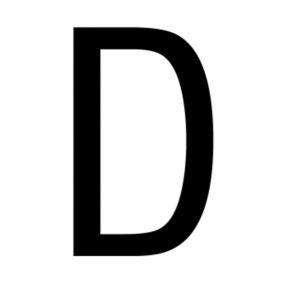
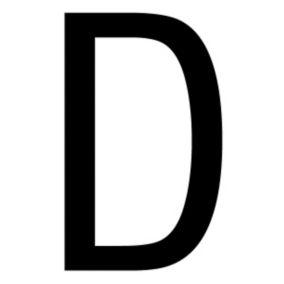
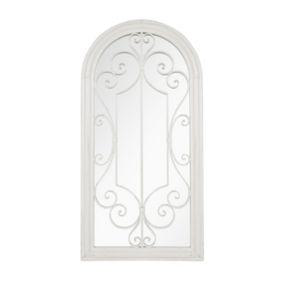
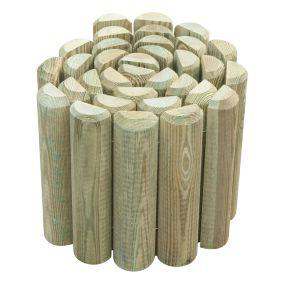
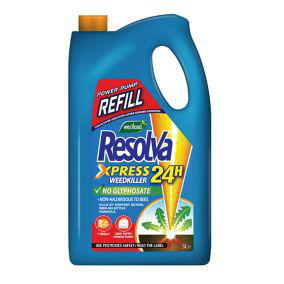
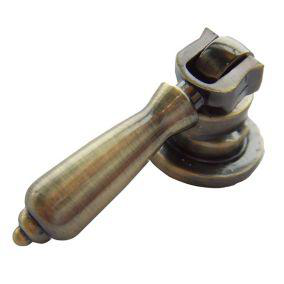
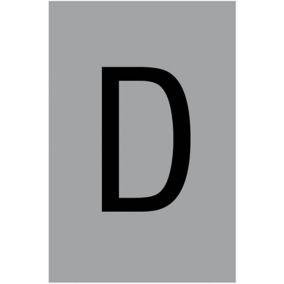
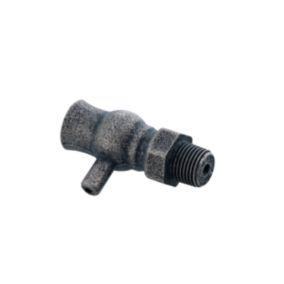
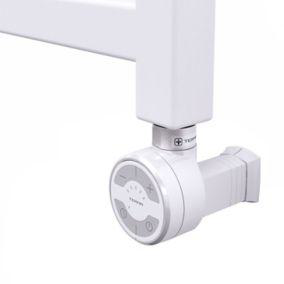
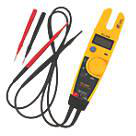
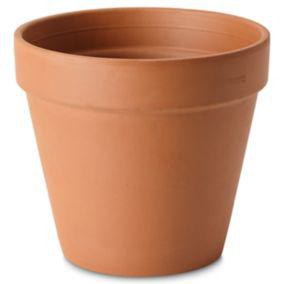
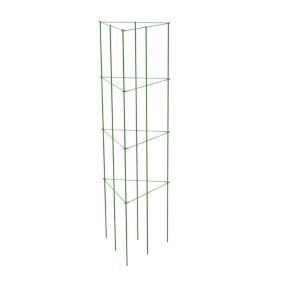
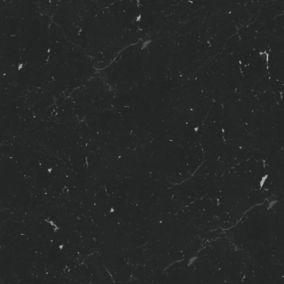
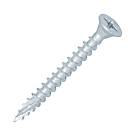
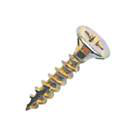
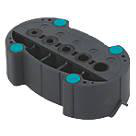
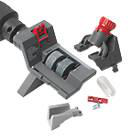
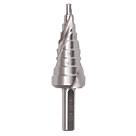
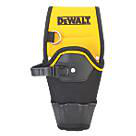
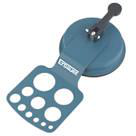
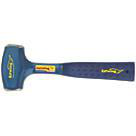
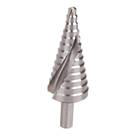
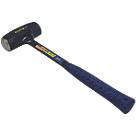
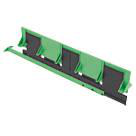
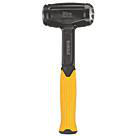
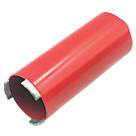
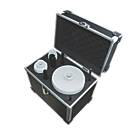
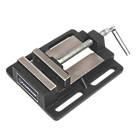
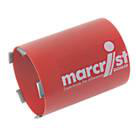
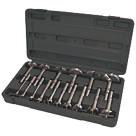

In [204]:
#
question = "drill"
#
dense_vec = dense_model.encode(question)
#
query_vec = bm25.encode_queries(question)
#
query_indices = query_vec['indices']
query_values = query_vec['values']
#
results = return_results(query_indices,query_values,dense_vec)  
#
dense_match = []
sparse_match = []

scores = []
for result in results[0]:
   dense_match.append(result.id)
   scores.append(result.score)
for result in results[1]:
   sparse_match.append(result.id)
   scores.append(result.score)
imageids,productids = get_image_ids(dense_match,sparse_match)
#create documents
docs = create_docs(productids,scores)
#
# used returned product ids to get images
display_result(imageids)

In [184]:
def hybrid_scale(dense, sparse, alpha: float):
    """Hybrid vector scaling using a convex combination

    alpha * dense + (1 - alpha) * sparse

    Args:
        dense: Array of floats representing
        sparse: a dict of `indices` and `values`
        alpha: float between 0 and 1 where 0 == sparse only
               and 1 == dense only
    """
    if alpha < 0 or alpha > 1:
        raise ValueError("Alpha must be between 0 and 1")
    # scale sparse and dense vectors to create hybrid search vecs
    hsparse = {
        'indices': sparse['indices'],
        'values':  [v * (1 - alpha) for v in sparse['values']]
    }
    hdense = [v * alpha for v in dense]
    return hdense, hsparse

53800
53807
53843
53839
53888
53797
53855
53891
53875
53867
53880
53786
53785
53808
53849



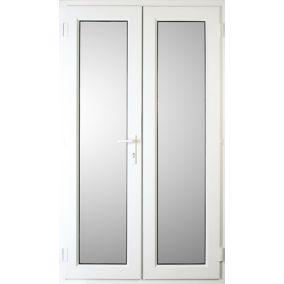
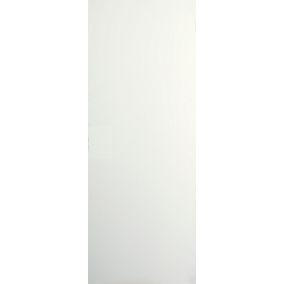
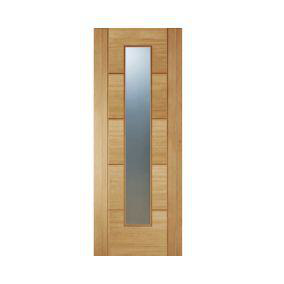
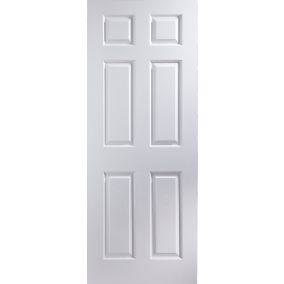
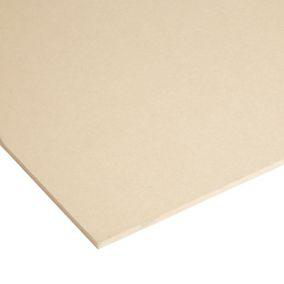
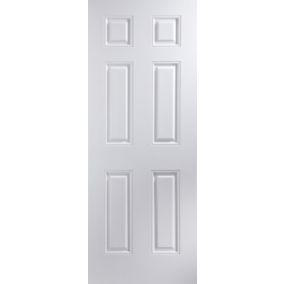
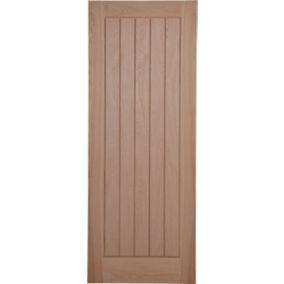
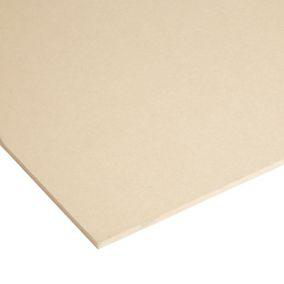
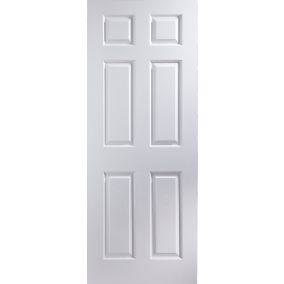
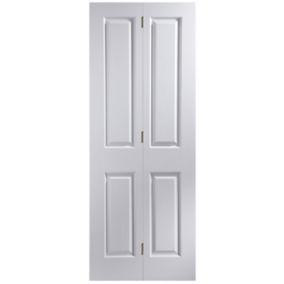
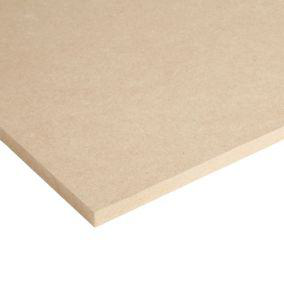
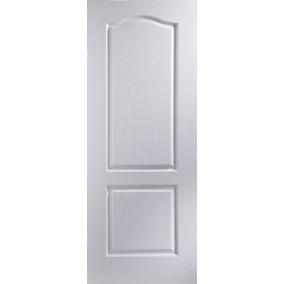
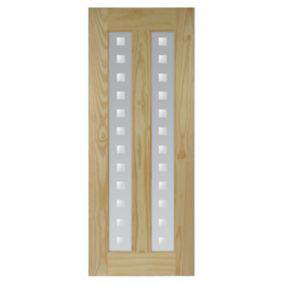
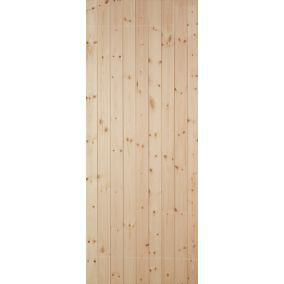
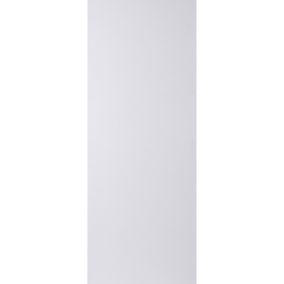
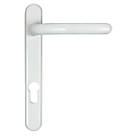
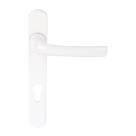
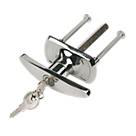
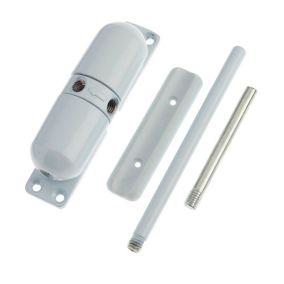
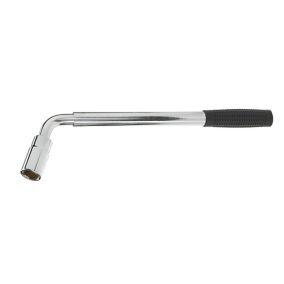
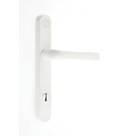
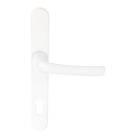
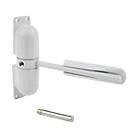
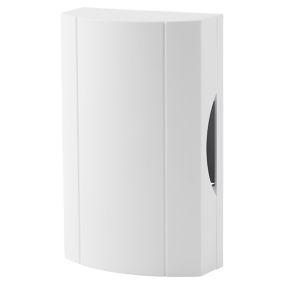
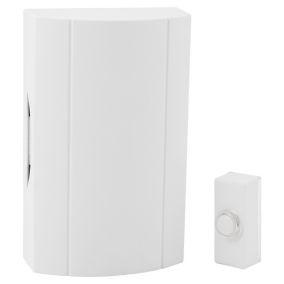
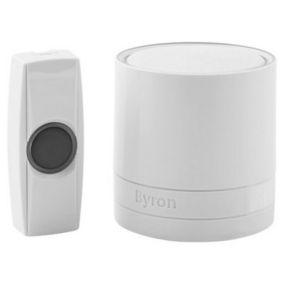
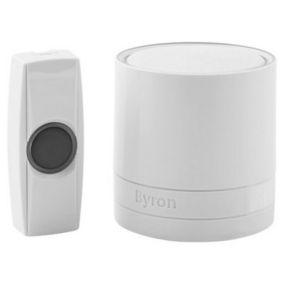
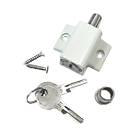
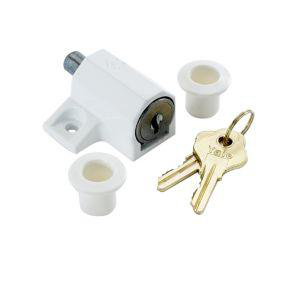
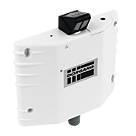

In [202]:
question2 = "white door handle"
#
dense_vector = dense_model.encode(question2)
#
query_vector = bm25.encode_queries(question2)
#
hdense, hsparse = hybrid_scale(dense_vector, query_vector, alpha=0.8)

query_indices_hybrid = hsparse['indices']
query_values_hybrid = hsparse['values']
results = return_results(query_indices_hybrid,query_values_hybrid,hdense)  
#
dense_match = []
sparse_match = []

scores = []
for result in results[0]:
   dense_match.append(result.id)
   scores.append(result.score)
for result in results[1]:
   sparse_match.append(result.id)
   scores.append(result.score)
imageids,productids = get_image_ids(dense_match,sparse_match)
#create documents
docs = create_docs(productids,scores)
#
# used returned product ids to get images
display_result(imageids)

{'indices': [4215858208, 2260452345], 'values': [0.25, 0.25]}
